In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

import astropy.units as u
import logging

from asgardpy.analysis import AsgardpyAnalysis
from asgardpy.config import AsgardpyConfig

from gammapy.data import DataStore
from gammapy.makers import SpectrumDatasetMaker, DatasetsMaker

In [2]:
from asgardpy.base.geom import generate_geom, get_source_position
from asgardpy.base.reduction import (
    generate_dl4_dataset,
    get_bkg_maker,
    get_dataset_maker,
    get_dataset_reference,
    get_exclusion_region_mask,
    get_filtered_observations,
    get_safe_mask_maker,
)
from asgardpy.data.dataset_1d import Dataset1DGeneration
from asgardpy.io.input_dl3 import DL3Files

In [3]:
os.environ['GAMMAPY_DATA']

'/fefs/aswg/workspace/chaitanya.priyadarshi/software/gammapy-tutorials/dataset/'

In [4]:
log = logging.getLogger("test 1d dataset")

In [5]:
config_file = "../asgardpy/tests/config_test_base.yaml"

In [6]:
config = AsgardpyConfig()

In [7]:
%%time
config_main = config.read(config_file)

CPU times: user 25.3 ms, sys: 1.49 ms, total: 26.8 ms
Wall time: 24.9 ms


# Update path of test data

In [8]:
config_main.dataset3d.instruments[0].input_dl3[0].input_dir = f"{os.environ['GAMMAPY_DATA']}fermipy-crab/"
config_main.dataset3d.instruments[0].input_dl3[1].input_dir = f"{os.environ['GAMMAPY_DATA']}fermipy-crab/"
config_main.dataset1d.instruments[0].input_dl3[0].input_dir = f"{os.environ['GAMMAPY_DATA']}hess-dl3-dr1/"

In [9]:
for g in config_main.general:
    print(g)

('log', LogConfig(level='info', filename='', filemode='w', format='', datefmt=''))
('outdir', PosixPath('.'))
('n_jobs', 10)
('parallel_backend', <ParallelBackendEnum.multi: 'multiprocessing'>)
('steps', [<AnalysisStepEnum.datasets_3d: 'datasets-3d'>, <AnalysisStepEnum.datasets_1d: 'datasets-1d'>, <AnalysisStepEnum.fit: 'fit'>, <AnalysisStepEnum.flux_points: 'flux-points'>])
('overwrite', True)
('stacked_dataset', True)


# Steps mentioned in the main config file

In [10]:
config_main.general.steps

[<AnalysisStepEnum.datasets_3d: 'datasets-3d'>,
 <AnalysisStepEnum.datasets_1d: 'datasets-1d'>,
 <AnalysisStepEnum.fit: 'fit'>,
 <AnalysisStepEnum.flux_points: 'flux-points'>]

# Target source information

In [11]:
for c in config_main.target:
    print(c)

('source_name', '4FGL J0534.5+2201i')
('sky_position', SkyPositionConfig(frame=<FrameEnum.icrs: 'icrs'>, lon=<Angle 83.633 deg>, lat=<Angle 22.02 deg>, radius=<Angle 0. deg>))
('use_uniform_position', True)
('models_file', PosixPath('.'))
('add_fov_bkg_model', False)
('use_catalog', CatalogConfig(name='', selection_radius=<Angle 0. deg>, exclusion_radius=<Angle 0. deg>))
('components', [SkyModelComponent(name='4FGL J0534.5+2201i', type='SkyModel', spectral=SpectralModelConfig(type='LogParabolaSpectralModel', parameters=[ModelParams(name='amplitude', value=1e-06, unit='cm-2 s-1 TeV-1', error=1.5e-07, min=1e-13, max=0.01, frozen=False), ModelParams(name='reference', value=0.01, unit='TeV', error=0.0, min=0.0001, max=100.0, frozen=True), ModelParams(name='alpha', value=1.7, unit='', error=0.1, min=0.5, max=5.0, frozen=False), ModelParams(name='beta', value=0.01, unit='', error=0.001, min=1e-06, max=1.0, frozen=False)], ebl_abs=EBLAbsorptionModel(filename=PosixPath('.'), reference='domingu

# 1D Datasets informations

In [12]:
for cc in config_main.dataset1d:
    print(cc)

('type', <ReductionTypeEnum.spectrum: '1d'>)
('instruments', [Dataset1DBaseConfig(name='HESS', input_dl3=[InputDL3Config(type='gadf-dl3', input_dir=PosixPath('/fefs/aswg/workspace/chaitanya.priyadarshi/software/gammapy-tutorials/dataset/hess-dl3-dr1'), glob_pattern={'dl3': 'data/hess_*fits.gz'})], input_dl4=False, dataset_info=Dataset1DInfoConfig(name='HESS', geom=GeomConfig(wcs=WcsConfig(skydir=SkyPositionConfig(frame=<FrameEnum.icrs: 'icrs'>, lon=<Angle 0. deg>, lat=<Angle 0. deg>, radius=<Angle 0. deg>), binsize=<Angle 0.02 deg>, proj=<ProjectionEnum.tan: 'TAN'>, map_frame_shape=MapFrameShapeConfig(width=<Angle 6. deg>, height=<Angle 6. deg>), binsize_irf=<Angle 0.2 deg>), selection=SelectionConfig(offset_max=<Angle 2.5 deg>), axes=[MapAxesConfig(name='energy', axis=EnergyAxisConfig(min=<Quantity 0.1 TeV>, max=<Quantity 100. TeV>, nbins=5, per_decade=True), axis_custom=EnergyEdgesCustomConfig(edges=[], unit='TeV')), MapAxesConfig(name='energy_true', axis=EnergyAxisConfig(min=<Quanti

In [13]:
%%time
analysis = AsgardpyAnalysis(config_main)

Setting logging config: {'level': 'INFO', 'filename': '', 'filemode': 'w', 'format': '', 'datefmt': ''}


CPU times: user 1.4 ms, sys: 123 µs, total: 1.52 ms
Wall time: 1.08 ms


In [14]:
analysis

# Prepare for a single 1D Dataset, based on instrument

In [15]:
instruments_list = config_main.dataset1d.instruments
print(len(instruments_list), "number of 1D dataset information provided")

config_1d_dataset = instruments_list[0]
print(f"Instrument selected is {config_1d_dataset.name}")

1 number of 1D dataset information provided
Instrument selected is HESS


# Run each Dataset1DGeneration step

In [16]:
%%time
generate_1d_dataset = Dataset1DGeneration(
    log, config_1d_dataset, config_main
)

CPU times: user 17 µs, sys: 0 ns, total: 17 µs
Wall time: 23.8 µs


# Initialized variables

In [17]:
print(generate_1d_dataset.config_1d_dataset_io)

[InputDL3Config(type='gadf-dl3', input_dir=PosixPath('/fefs/aswg/workspace/chaitanya.priyadarshi/software/gammapy-tutorials/dataset/hess-dl3-dr1'), glob_pattern={'dl3': 'data/hess_*fits.gz'})]


In [18]:
print(generate_1d_dataset.config_1d_dataset_info)

name='HESS' geom=GeomConfig(wcs=WcsConfig(skydir=SkyPositionConfig(frame=<FrameEnum.icrs: 'icrs'>, lon=<Angle 0. deg>, lat=<Angle 0. deg>, radius=<Angle 0. deg>), binsize=<Angle 0.02 deg>, proj=<ProjectionEnum.tan: 'TAN'>, map_frame_shape=MapFrameShapeConfig(width=<Angle 6. deg>, height=<Angle 6. deg>), binsize_irf=<Angle 0.2 deg>), selection=SelectionConfig(offset_max=<Angle 2.5 deg>), axes=[MapAxesConfig(name='energy', axis=EnergyAxisConfig(min=<Quantity 0.1 TeV>, max=<Quantity 100. TeV>, nbins=5, per_decade=True), axis_custom=EnergyEdgesCustomConfig(edges=[], unit='TeV')), MapAxesConfig(name='energy_true', axis=EnergyAxisConfig(min=<Quantity 0.1 TeV>, max=<Quantity 100. TeV>, nbins=5, per_decade=True), axis_custom=EnergyEdgesCustomConfig(edges=[], unit='TeV'))], from_events_file=True) observation=ObservationsConfig(obs_ids=[23523, 23526, 23559, 23592], obs_file=PosixPath('.'), obs_time=TimeIntervalsConfig(format=<TimeFormatEnum.iso: 'iso'>, intervals=[TimeRangeConfig(start=<Time obj

In [19]:
print(generate_1d_dataset.config_target)

source_name='4FGL J0534.5+2201i' sky_position=SkyPositionConfig(frame=<FrameEnum.icrs: 'icrs'>, lon=<Angle 83.633 deg>, lat=<Angle 22.02 deg>, radius=<Angle 0. deg>) use_uniform_position=True models_file=PosixPath('.') add_fov_bkg_model=False use_catalog=CatalogConfig(name='', selection_radius=<Angle 0. deg>, exclusion_radius=<Angle 0. deg>) components=[SkyModelComponent(name='4FGL J0534.5+2201i', type='SkyModel', spectral=SpectralModelConfig(type='LogParabolaSpectralModel', parameters=[ModelParams(name='amplitude', value=1e-06, unit='cm-2 s-1 TeV-1', error=1.5e-07, min=1e-13, max=0.01, frozen=False), ModelParams(name='reference', value=0.01, unit='TeV', error=0.0, min=0.0001, max=100.0, frozen=True), ModelParams(name='alpha', value=1.7, unit='', error=0.1, min=0.5, max=5.0, frozen=False), ModelParams(name='beta', value=0.01, unit='', error=0.001, min=1e-06, max=1.0, frozen=False)], ebl_abs=EBLAbsorptionModel(filename=PosixPath('.'), reference='dominguez', type='EBLAbsorptionNormSpectr

### First check for the given file list if they are readable or not.

In [20]:
%%time
file_list = {}
dl3_info = DL3Files(
    generate_1d_dataset.config_1d_dataset_io[0], 
    log=generate_1d_dataset.log
)

CPU times: user 50 µs, sys: 85 µs, total: 135 µs
Wall time: 113 µs


In [21]:
dl3_info

In [22]:
%%time
dl3_info.list_dl3_files()

CPU times: user 798 µs, sys: 661 µs, total: 1.46 ms
Wall time: 1.08 ms


In [23]:
print(f"Reading from {len(dl3_info.events_files)} DL3 files")
for e in dl3_info.events_files:
    print(e)

Reading from 105 DL3 files
/fefs/aswg/workspace/chaitanya.priyadarshi/software/gammapy-tutorials/dataset/hess-dl3-dr1/data/hess_dl3_dr1_obs_id_020136.fits.gz
/fefs/aswg/workspace/chaitanya.priyadarshi/software/gammapy-tutorials/dataset/hess-dl3-dr1/data/hess_dl3_dr1_obs_id_020137.fits.gz
/fefs/aswg/workspace/chaitanya.priyadarshi/software/gammapy-tutorials/dataset/hess-dl3-dr1/data/hess_dl3_dr1_obs_id_020151.fits.gz
/fefs/aswg/workspace/chaitanya.priyadarshi/software/gammapy-tutorials/dataset/hess-dl3-dr1/data/hess_dl3_dr1_obs_id_020275.fits.gz
/fefs/aswg/workspace/chaitanya.priyadarshi/software/gammapy-tutorials/dataset/hess-dl3-dr1/data/hess_dl3_dr1_obs_id_020282.fits.gz
/fefs/aswg/workspace/chaitanya.priyadarshi/software/gammapy-tutorials/dataset/hess-dl3-dr1/data/hess_dl3_dr1_obs_id_020283.fits.gz
/fefs/aswg/workspace/chaitanya.priyadarshi/software/gammapy-tutorials/dataset/hess-dl3-dr1/data/hess_dl3_dr1_obs_id_020301.fits.gz
/fefs/aswg/workspace/chaitanya.priyadarshi/software/gamm

## Get Observations object

In [24]:
datastore = DataStore.from_dir(generate_1d_dataset.config_1d_dataset_io[0].input_dir)

In [25]:
datastore.obs_table

OBS_ID,RA_PNT,DEC_PNT,GLON_PNT,GLAT_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,OBJECT,RA_OBJ,DEC_OBJ,OFFSET_OBJ,ONTIME,LIVETIME,DEADC,TSTART,TSTOP,DATE-OBS,TIME-OBS,DATE-END,TIME-END,N_TELS,TELLIST,QUALITY,MUONEFF,EVENT_COUNT,TARGET_NAME,TARGET_TAG,TARGET_OFFSET,SAFE_ENERGY_LO,SAFE_ENERGY_HI
,deg,deg,deg,deg,deg,deg,deg,,deg,deg,deg,s,s,,s,s,,,,,,,,,,,,deg,TeV,TeV
int64,float32,float32,float32,float32,float32,float32,float32,bytes18,float32,float32,float32,float32,float32,float32,float64,float64,bytes10,bytes12,bytes10,bytes12,int64,bytes7,int64,float32,int64,bytes21,bytes14,float32,float32,float32
20136,228.6125,-58.771667,320.56754,-0.8857012,38.512962,51.487038,195.73102,MSH15-52,228.6125,-59.271667,0.5,1682.0,1521.0269,0.9042966,101962602.0,101964284.0,2004-03-26,02:57:46.184,2004-03-26,03:25:48.184,4,"1,2,3,4",0,1.2132596,11243,MSH 15-52,msh1552,0.38821736,0.40738028,100.0
20137,228.6125,-59.771667,320.04724,-1.7397733,40.21616,49.78384,199.6482,MSH15-52,228.6125,-59.271667,0.5,902.0,819.2054,0.90821,101964441.0,101965343.0,2004-03-26,03:28:25.184,2004-03-26,03:43:27.184,4,"1,2,3,4",0,1.2139559,5693,MSH 15-52,msh1552,0.6156251,0.40738028,100.0
20151,228.6125,-58.771667,320.56754,-0.8857012,37.164658,52.835342,190.97171,custom,228.6125,-59.271667,0.5,1683.0,1530.479,0.9093755,102047232.0,102048915.0,2004-03-27,02:28:16.184,2004-03-27,02:56:19.184,4,"1,2,3,4",0,1.2214733,10722,MSH 15-52,msh1552,0.38821736,0.40738028,100.0
20275,187.27792,2.552389,289.7155,64.849686,36.18243,53.81757,49.144917,3C 273,187.27792,2.052389,0.5,1683.0,1525.8447,0.90662193,103665036.0,103666719.0,2004-04-14,19:51:40.184,2004-04-14,20:19:43.184,4,"1,2,3,4",0,1.121256,10646,Off data,offdata,--,0.33113113,100.0
20282,228.6125,-58.771667,320.56754,-0.8857012,37.13134,52.86866,169.21602,MSH 15-5-02,228.6125,-59.271667,0.5,1687.0,1543.3231,0.9148329,103678269.0,103679956.0,2004-04-14,23:32:13.184,2004-04-15,00:00:20.184,4,"1,2,3,4",0,1.1495326,11063,MSH 15-52,msh1552,0.38821736,0.40738028,100.0
20283,228.6125,-59.771667,320.04724,-1.7397733,36.221436,53.778564,175.77263,MSH 15-5-02,228.6125,-59.271667,0.5,1683.0,1547.8253,0.9196823,103680087.0,103681770.0,2004-04-15,00:02:31.184,2004-04-15,00:30:34.184,4,"1,2,3,4",0,1.1512518,7628,MSH 15-52,msh1552,0.6156251,0.3801894,100.0
20301,228.6125,-58.771667,320.56754,-0.8857012,36.839905,53.160095,171.07347,MSH 15-5-02,228.6125,-59.271667,0.5,1683.0,1534.0626,0.9115048,103764878.0,103766561.0,2004-04-15,23:35:42.184,2004-04-16,00:03:45.184,4,"1,2,3,4",0,1.1503073,11624,MSH 15-52,msh1552,0.38821736,0.40738028,100.0
20302,228.6125,-59.771667,320.04724,-1.7397733,36.11632,53.88368,177.10521,MSH 15-5-02,228.6125,-59.271667,0.5,1682.0,1535.3478,0.9128108,103766698.0,103768380.0,2004-04-16,00:06:02.184,2004-04-16,00:34:04.184,4,"1,2,3,4",0,1.1493496,11794,MSH 15-52,msh1552,0.6156251,0.3801894,100.0


In [26]:
observations = get_filtered_observations(
    dl3_path=generate_1d_dataset.config_1d_dataset_io[0].input_dir,
    obs_config=generate_1d_dataset.config_1d_dataset_info.observation,
    log=generate_1d_dataset.log,
)

Observation ID list selected: 23523 23526 23559 23592
Observations selected: 4 out of 4.


In [27]:
print(observations)

Observations
Number of observations: 4
Observation

	obs id            : 23523 
 	tstart            : 53343.92
	tstop             : 53343.94
	duration          : 1687.00 s
	pointing (icrs)   : 83.6 deg, 21.5 deg

	deadtime fraction : 6.2%
Observation

	obs id            : 23526 
 	tstart            : 53343.95
	tstop             : 53343.97
	duration          : 1683.00 s
	pointing (icrs)   : 83.6 deg, 22.5 deg

	deadtime fraction : 6.6%
Observation

	obs id            : 23559 
 	tstart            : 53345.96
	tstop             : 53345.98
	duration          : 1686.00 s
	pointing (icrs)   : 85.3 deg, 22.0 deg

	deadtime fraction : 6.4%
Observation

	obs id            : 23592 
 	tstart            : 53347.91
	tstop             : 53347.93
	duration          : 1686.00 s
	pointing (icrs)   : 82.0 deg, 22.0 deg

	deadtime fraction : 6.2%



In [28]:
print("Using the list of required IRFs:", generate_1d_dataset.config_1d_dataset_info.observation.required_irfs)
print("Selected observations from the given DataStore:", observations.ids)

Using the list of required IRFs: [<RequiredHDUEnum.aeff: 'aeff'>, <RequiredHDUEnum.edisp: 'edisp'>]
Selected observations from the given DataStore: ['23523', '23526', '23559', '23592']


# Create Base geometry for the Dataset

In [29]:
center_pos = get_source_position(target_region=generate_1d_dataset.config_1d_dataset_info.on_region)
print(center_pos)

{'center': <SkyCoord (ICRS): (ra, dec) in deg
    (83.633, 22.02)>, 'radius': <Angle 0.2 deg>}


In [30]:
geom = generate_geom(
    tag="1d", 
    geom_config=generate_1d_dataset.config_1d_dataset_info.geom, 
    center_pos=center_pos
)
print(geom)

RegionGeom

	region     : CircleSkyRegion
	axes       : ['lon', 'lat', 'energy']
	shape      : (1, 1, 15)
	ndim       : 3
	frame      : icrs
	center     : 83.6 deg, 22.0 deg



## Create the base dataset template and get all the Dataset Reduction makers 

In [31]:
dataset_reference = get_dataset_reference(
    tag="1d", 
    geom=geom, 
    geom_config=generate_1d_dataset.config_1d_dataset_info.geom
)
print(dataset_reference)

SpectrumDataset
---------------

  Name                            : j7lCadAC 

  Total counts                    : 0 
  Total background counts         : 0.00
  Total excess counts             : 0.00

  Predicted counts                : 0.00
  Predicted background counts     : 0.00
  Predicted excess counts         : nan

  Exposure min                    : 0.00e+00 m2 s
  Exposure max                    : 0.00e+00 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 0 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




In [32]:
%%time
dataset_maker = get_dataset_maker(
    tag="1d",
    dataset_config=generate_1d_dataset.config_1d_dataset_info,
)
print(dataset_maker)

SpectrumDatasetMaker
--------------------

  selection               : {<MapSelectionEnum.counts: 'counts'>, <MapSelectionEnum.exposure: 'exposure'>, <MapSelectionEnum.edisp: 'edisp'>}
  containment_correction  : True
  use_region_center       : True

CPU times: user 88 µs, sys: 129 µs, total: 217 µs
Wall time: 233 µs


In [33]:
%%time
safe_maker = get_safe_mask_maker(
    safe_config=generate_1d_dataset.config_1d_dataset_info.safe_mask
)
print(safe_maker)

SafeMaskMaker
-------------

  methods      : {<SafeMaskMethodsEnum.aeff_max: 'aeff-max'>}
  aeff_percent : 10
  bias_percent : 10
  offset_max   : 3.0 deg

CPU times: user 209 µs, sys: 310 µs, total: 519 µs
Wall time: 459 µs


In [34]:
%%time
excluded_geom = generate_geom(
    tag="1d-ex", 
    geom_config=generate_1d_dataset.config_1d_dataset_info.geom, 
    center_pos=center_pos
)

exclusion_mask = get_exclusion_region_mask(
    exclusion_params=generate_1d_dataset.config_1d_dataset_info.background.exclusion,
    exclusion_regions=generate_1d_dataset.exclusion_regions,
    excluded_geom=excluded_geom,
    config_target=generate_1d_dataset.config_target,
    geom_config=generate_1d_dataset.config_1d_dataset_info.geom,
    log=generate_1d_dataset.log,
)
print(exclusion_mask)

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat']
	shape : (300, 300)
	ndim  : 2
	unit  : 
	dtype : bool

CPU times: user 31.8 ms, sys: 7.12 ms, total: 38.9 ms
Wall time: 37.6 ms


In [35]:
%%time
bkg_maker = get_bkg_maker(
    bkg_config=generate_1d_dataset.config_1d_dataset_info.background,
    exclusion_mask=exclusion_mask,
)

CPU times: user 121 µs, sys: 0 ns, total: 121 µs
Wall time: 129 µs


In [36]:
print(bkg_maker)
print(bkg_maker.region_finder)
print("Number of Wobble OFF regions selected:", bkg_maker.region_finder.n_off_regions)

ReflectedRegionsBackgroundMaker
-------------------------------

  region_finder  : <gammapy.makers.background.reflected.WobbleRegionsFinder object at 0x7f09c862c910>
  exclusion_mask : WcsNDMap

  geom  : WcsGeom 
  axes  : ['lon', 'lat']
  shape : (300, 300)
  ndim  : 2
  unit  : 
  dtype : bool


Number of Wobble OFF regions selected: 1


In [37]:
%%time
generate_1d_dataset.datasets = generate_dl4_dataset(
    tag="1d",
    observations=observations,
    dataset_reference=dataset_reference,
    dataset_maker=dataset_maker,
    bkg_maker=bkg_maker,
    safe_maker=safe_maker,
    n_jobs=generate_1d_dataset.n_jobs,
    parallel_backend=generate_1d_dataset.parallel_backend,
)

Using 4 processes to compute Data reduction
Computing dataset for observation 23523
Running SpectrumDatasetMaker
Computing dataset for observation 23526
Running SpectrumDatasetMaker
Computing dataset for observation 23559
Running SpectrumDatasetMaker
Computing dataset for observation 23592
Running SpectrumDatasetMaker
Running SafeMaskMaker
Running SafeMaskMaker
Running SafeMaskMaker
Running ReflectedRegionsBackgroundMaker
Running SafeMaskMaker
Running ReflectedRegionsBackgroundMaker
Running ReflectedRegionsBackgroundMaker
Running ReflectedRegionsBackgroundMaker


CPU times: user 121 ms, sys: 62.3 ms, total: 183 ms
Wall time: 1.03 s


In [38]:
print(generate_1d_dataset.datasets)

Datasets
--------

Dataset 0: 

  Type       : SpectrumDatasetOnOff
  Name       : e2-iN0zy
  Instrument : HESS
  Models     : 

Dataset 1: 

  Type       : SpectrumDatasetOnOff
  Name       : q6-i59Fx
  Instrument : HESS
  Models     : 

Dataset 2: 

  Type       : SpectrumDatasetOnOff
  Name       : e57LNXkD
  Instrument : HESS
  Models     : 

Dataset 3: 

  Type       : SpectrumDatasetOnOff
  Name       : kGX0FT7o
  Instrument : HESS
  Models     : 




In [39]:
%%time
generate_1d_dataset.update_dataset(observations)

CPU times: user 23 µs, sys: 33 µs, total: 56 µs
Wall time: 62.2 µs


In [40]:
print(generate_1d_dataset.datasets)

Datasets
--------

Dataset 0: 

  Type       : SpectrumDatasetOnOff
  Name       : 23523
  Instrument : HESS
  Models     : 

Dataset 1: 

  Type       : SpectrumDatasetOnOff
  Name       : 23526
  Instrument : HESS
  Models     : 

Dataset 2: 

  Type       : SpectrumDatasetOnOff
  Name       : 23559
  Instrument : HESS
  Models     : 

Dataset 3: 

  Type       : SpectrumDatasetOnOff
  Name       : 23592
  Instrument : HESS
  Models     : 




In [41]:
info_table = generate_1d_dataset.datasets.info_table(cumulative=True)

In [42]:
stacked_dataset = generate_1d_dataset.datasets.stack_reduce(name=config_1d_dataset.name)

In [43]:
print(stacked_dataset)

SpectrumDatasetOnOff
--------------------

  Name                            : HESS 

  Total counts                    : 862 
  Total background counts         : 112.00
  Total excess counts             : 750.00

  Predicted counts                : 487.00
  Predicted background counts     : 487.00
  Predicted excess counts         : nan

  Exposure min                    : 2.63e+08 m2 s
  Exposure max                    : 3.09e+09 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 11 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 670.95

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 112 
  Acceptance                      : 15 
  Acceptance off                  : 15 



# Some Basic plots from the Dataset

In [44]:
info_table

name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str7,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
stacked,266,230.0,14.071118591088961,36.0,151.0,151.0,nan,44945484.0,972820352.0,1581.736764695497,1687.0000000000016,0.16816957532829943,0.02275979214969466,0.14540978317860476,15,11,wstat,205.28610211617124,36,11.0,11.0,1.0
stacked,496,434.0,19.602439504920714,62.0,279.0,279.0,nan,155443520.0,1815084800.0,3154.4235137812757,3369.9999999999964,0.15723950757817998,0.019654938447272497,0.13758456913090747,15,11,wstat,390.6824869192629,62,11.0,11.0,1.0
stacked,677,599.0,23.342705964953737,78.0,377.5,377.5,nan,233270016.0,2419728128.0,4732.546993609518,5056.000000000001,0.14305193396160057,0.01648161129838234,0.12657032266321822,15,11,wstat,551.3445322223419,78,11.0,11.0,1.0
stacked,862,750.0,25.596119276746272,112.0,487.0,487.0,nan,263188144.0,3088673280.0,6313.811659421768,6741.999999999996,0.136526087013331,0.017738888335838827,0.11878719867749216,15,11,wstat,670.9491782037578,112,11.0,11.0,1.0


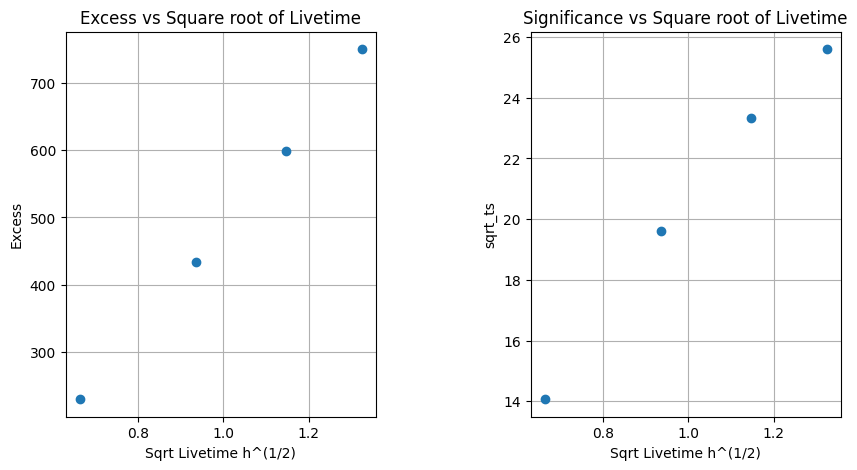

In [45]:
# Plot temporal evolution of excess events and significance value
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(
    np.sqrt(info_table["livetime"].to("h")), info_table["excess"], marker="o", ls="none"
)
plt.plot(info_table["livetime"].to("h")[-1:1], info_table["excess"][-1:1], 'r')
plt.xlabel("Sqrt Livetime h^(1/2)")
plt.ylabel("Excess")
plt.grid()
plt.title('Excess vs Square root of Livetime')

plt.subplot(122)
plt.plot(
    np.sqrt(info_table["livetime"].to("h")),
    info_table["sqrt_ts"],
    marker="o",
    ls="none",
)
plt.grid()
plt.xlabel("Sqrt Livetime h^(1/2)")
plt.ylabel("sqrt_ts")
plt.title('Significance vs Square root of Livetime')
plt.subplots_adjust(wspace=0.5)

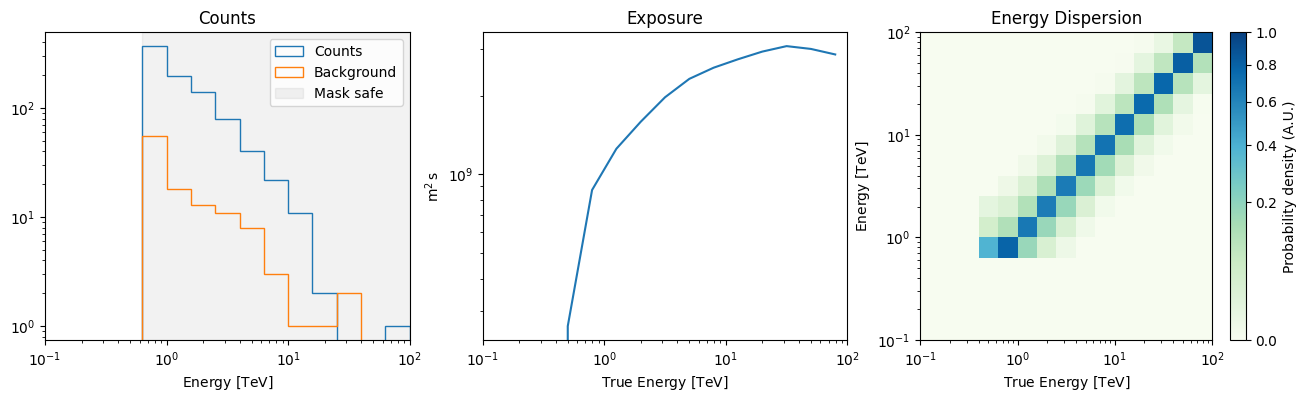

In [46]:
stacked_dataset.peek()